In [3]:
cd ..

/home/modan9012/mmsegmentation


In [4]:
import torch
print(torch.__version__) 
print(torch.cuda.is_available())  


1.12.0+cu116
True


In [5]:
import mmcv
print(mmcv.__version__)

import mmseg
print(mmseg.__version__)

2.1.0
1.2.2


In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import mmcv
import mmengine
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [7]:
# dataset root와 이미지, annotation이 위치할 디렉토리 정의
data_root = '/home/modan9012/mmsegmentation/datasets/'
img_dir = 'images/'
ann_dir = 'labels'
# 각 클래스에 대한 팔레트(색상)을 정의
classes = ('background', 'kidney')
palette = [[128,0,0],[0,128,0]]

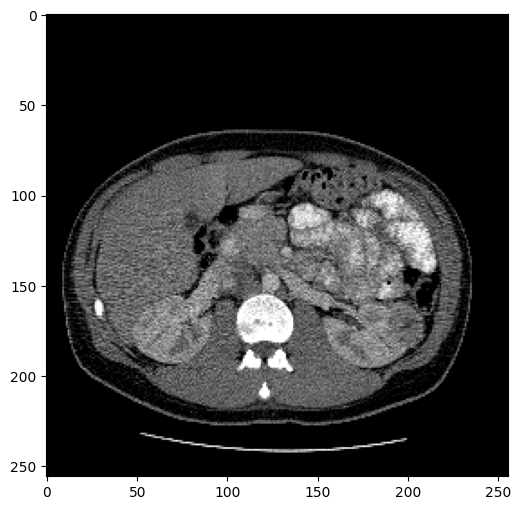

In [8]:
# 다운받은 데이터셋 확인
img = mmcv.imread('/home/modan9012/mmsegmentation/datasets/images/086_040.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

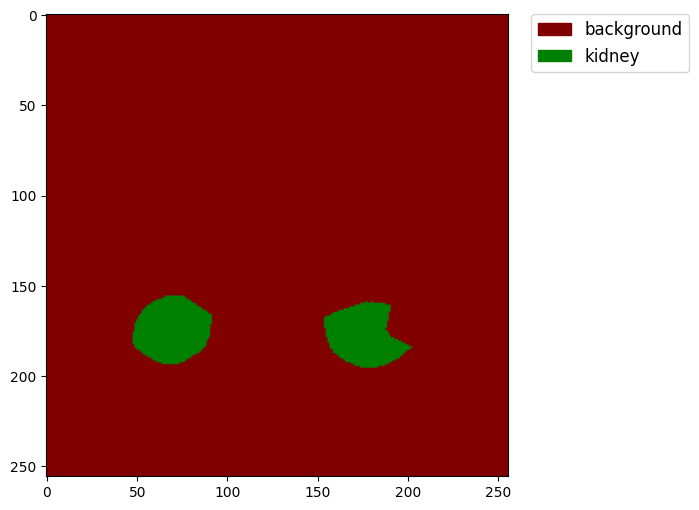

In [9]:
# 변환된 Segmentation map 확인
img = Image.open(f'{data_root}{ann_dir}/086_040.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch for every color(palette)
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

In [10]:
# 파일명 리스트 생성
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
train_length = int(len(filename_list)*0.8)
print(f'train_length: {train_length}')
print(f'val_length: {len(filename_list) - train_length}')

train_length: 7069
val_length: 1768


In [11]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class KiTS21Datasets(BaseSegDataset):
	# 클래스, 팔레트 정보에대한 딕셔너리 METAINFO 생성
  METAINFO = dict(classes = classes, reduce_zero_label=False, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [25]:
cd mmsegmentation

/home/modan9012/mmsegmentation


In [12]:
from mmengine import Config
cfg = Config.fromfile('segmenter_swin-t_mask_8xb1-160k_ade20k-512x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
ann_dir = 'labels'
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'
crop_size = (
    512,
    512,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = '/home/modan9012/mmsegmentation/datasets/'
dataset_type = 'ADE20KDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=True, interval=10, type='CheckpointHook'),
    early_stopping=dict(
        min_delta=0.001,
        monitor='val_loss',
        patience=10,
        type='EarlyStoppingHook'),
    logger=dict(interval=1, log_metric_by_epoch=True, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed

In [13]:
# norm_cfg와 crop_size는 기본 설정에 이미 있을 가능성이 높습니다.
cfg.crop_size = (256,256)
cfg.model.data_preprocessor.size = (256, 256)
cfg.model.decode_head.num_classes=3
cfg.model.decode_head.out_channels= 3


# 최적화 설정
cfg.optim_wrapper.optimizer.lr = 0.001

# 데이터셋 타입과 경로를 수정
cfg.dataset_type = 'KiTS21Datasets'
cfg.data_root = '/home/modan9012/mmsegmentation/datasets/'
cfg.train_dataloader.dataset.reduce_zero_label = False
cfg.val_dataloader.dataset.reduce_zero_label = False
cfg.test_dataloader.dataset.reduce_zero_label = False


# 트레이닝 파이프라인을 설정
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='RandomResize', scale=(256, 256), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]

# validation 파이프라인 설정
val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(256, 256), keep_ratio=True),
    dict(type='LoadAnnotations', reduce_zero_label=False),  
    dict(type='PackSegInputs'),
]

cfg.train_dataloader = dict(
    batch_size=8, #배치사이즈 24
    dataset=dict(
        type='KiTS21Datasets',
        data_root=data_root,
        data_prefix=dict(img_path=img_dir, seg_map_path=ann_dir),
        pipeline=train_pipeline,
        reduce_zero_label=False,  # 여기서 reduce_zero_label 설정
        ann_file='splits/train.txt',
    ),
    num_workers=4,
    persistent_workers=True,
    sampler=dict(shuffle=True, type='DefaultSampler')
)

cfg.val_dataloader = dict(
    batch_size=1,
    dataset=dict(
        type='KiTS21Datasets',
        data_root=data_root,
        data_prefix=dict(img_path=img_dir, seg_map_path=ann_dir),
        pipeline=val_pipeline,
        reduce_zero_label=False,  # 여기서 reduce_zero_label 설정
        ann_file='splits/val.txt',
    ),
    num_workers=4,
    persistent_workers=True,
    sampler=dict(shuffle=False, type='DefaultSampler')
)

cfg.train_cfg.val_interval=5

# 사전학습된 모델 checkpoint 불러오기
# cfg.load_from = 'swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'

# 로그 디렉토리 설정
cfg.work_dir = './work_dirs/Swin-Seg/batch8lr0.001'

# 결과 재현을 위한 시드 값을 설정
cfg['randomness'] = dict(seed=0)

# 최종 설정(config)을 출력
print(f'Config:\n{cfg.pretty_text}')

Config:
ann_dir = 'labels'
backbone_norm_cfg = dict(eps=1e-06, requires_grad=True, type='LN')
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        127.5,
        127.5,
        127.5,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        127.5,
        127.5,
        127.5,
    ],
    type='SegDataPreProcessor')
data_root = '/home/modan9012/mmsegmentation/datasets/'
dataset_type = 'KiTS21Datasets'
default_hooks = dict(
    checkpoint=dict(by_epoch=True, interval=10, type='CheckpointHook'),
    early_stopping=dict(
        min_delta=0.001,
        monitor='val_loss',
        patience=10,
        type='EarlyStoppingHook'),
    logger=dict(interval=1, log_metric_by_epoch=True, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_see

In [14]:
from mmengine.runner import Runner


# Runner 생성
runner = Runner.from_cfg(cfg)


06/05 14:41:25 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.0+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-

/home/modan9012/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/05 14:41:28 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/05 14:41:28 - mmengine - DEBUG - Modules of mmseg's hook registry have been automatically imported from mmseg.engine.hooks
06/05 14:41:28 - mmengine - DEBUG - Get class `RuntimeInfoHook` from "hook" registry in "mmengine"
06/05 14:41:28 - mmengine - DEBUG - An `RuntimeInfoHook` instance is built from registry, and its implementation can be found in mmengine.hooks.runtime_info_hook
06/05 14:41:28 - mmengine - DEBUG - Get class `IterTimerHook` from "hook" registry in "mmengine"
06/05 14:41:28 - mmengine - DEBUG - An `IterTimerHook` instance is built from registry, and its implementation can be found in mmengine.hooks.iter_timer_hook
06/05 14:41:28 - mmengine - DEBUG - Get class `DistSamplerSeedHook` from "hook" registry in "mmengine"
06/05 14:41:28 - mmengine - DEBUG - An `DistSamplerSeedHook` instanc

In [ ]:
# 모델 학습 진행
runner.train()

06/05 14:41:31 - mmengine - DEBUG - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
06/05 14:41:31 - mmengine - DEBUG - Get class `EpochBasedTrainLoop` from "loop" registry in "mmengine"
06/05 14:41:31 - mmengine - DEBUG - Modules of mmseg's dataset registry have been automatically imported from mmseg.datasets
06/05 14:41:31 - mmengine - DEBUG - Get class `KiTS21Datasets` from "dataset" registry in "mmseg"
06/05 14:41:31 - mmengine - DEBUG - Modules of mmseg's transform registry have been automatically imported from mmseg.datasets.transforms
06/05 14:41:31 - mmengine - DEBUG - Get class `LoadImageFromFile` from "transform" registry in "mmengine"
06/05 14:41:31 - mmengine - DEBUG - An `LoadImageFromFile` instance is built from registry, and its implementation can be found in mmcv.transforms.loading
06/05 14:41:31 - mmengine - DEBUG - Get class `LoadAnnotations` from "transform" registry in "mmseg"
06/05 14:41:31 - mm

/home/modan9012/mmsegmentation/mmseg/datasets/transforms/loading.py:84: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


06/05 14:41:31 - mmengine - DEBUG - An `KiTS21Datasets` instance is built from registry, and its implementation can be found in __main__
06/05 14:41:31 - mmengine - DEBUG - Get class `DefaultSampler` from "data sampler" registry in "mmengine"
06/05 14:41:31 - mmengine - DEBUG - An `DefaultSampler` instance is built from registry, and its implementation can be found in mmengine.dataset.sampler
06/05 14:41:31 - mmengine - DEBUG - Get class `pseudo_collate` from "function" registry in "mmengine"
06/05 14:41:31 - mmengine - DEBUG - Modules of mmseg's metric registry have been automatically imported from mmseg.evaluation
06/05 14:41:31 - mmengine - DEBUG - Get class `IoUMetric` from "metric" registry in "mmseg"
06/05 14:41:31 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
06/05 14:41:31 - mmengine - DEBUG - An `IoUMetric` instance is built from registry, and its implementation can be found in mmseg.evaluation.metrics.iou_metric
06/05 14:41:31 - mmengine - DEBUG - An

### inference 결과 시각화

Seg_Swin : batch 16, lr 0.01, Epoch 50, Iter 27100

- mmsegmentation/work_dirs/Seg_Swin/batch16lr0.01epoch50/20240519_151056/vis_data/
- 로그 파일 : /20240519_152911.json
- validation 결과 이미지 : vis_image 폴더

05/20 09:19:17 - mmengine - DEBUG - Get class `EncoderDecoder` from "model" registry in "mmseg"
05/20 09:19:17 - mmengine - DEBUG - Get class `SegDataPreProcessor` from "model" registry in "mmseg"
05/20 09:19:17 - mmengine - DEBUG - An `SegDataPreProcessor` instance is built from registry, and its implementation can be found in mmseg.models.data_preprocessor
05/20 09:19:17 - mmengine - DEBUG - Get class `SwinTransformer` from "model" registry in "mmseg"
05/20 09:19:17 - mmengine - DEBUG - Get class `Conv2d` from "model" registry in "mmengine"
05/20 09:19:17 - mmengine - DEBUG - Get class `LayerNorm` from "model" registry in "mmengine"
05/20 09:19:17 - mmengine - DEBUG - Get class `LayerNorm` from "model" registry in "mmengine"
05/20 09:19:17 - mmengine - DEBUG - Get class `LayerNorm` from "model" registry in "mmengine"
05/20 09:19:17 - mmengine - DEBUG - Get class `DropPath` from "model" registry in "mmengine"
05/20 09:19:17 - mmengine - DEBUG - An `DropPath` instance is built from reg

/home/modan9012/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


05/20 09:19:18 - mmengine - DEBUG - Get class `LoadImageFromNDArray` from "transform" registry in "mmseg"
05/20 09:19:18 - mmengine - DEBUG - An `LoadImageFromNDArray` instance is built from registry, and its implementation can be found in mmseg.datasets.transforms.loading
05/20 09:19:18 - mmengine - DEBUG - Get class `Resize` from "transform" registry in "mmseg"
05/20 09:19:18 - mmengine - DEBUG - An `Resize` instance is built from registry, and its implementation can be found in mmseg.datasets.transforms.transforms
05/20 09:19:18 - mmengine - DEBUG - Get class `PackSegInputs` from "transform" registry in "mmseg"
05/20 09:19:18 - mmengine - DEBUG - An `PackSegInputs` instance is built from registry, and its implementation can be found in mmseg.datasets.transforms.formatting
05/20 09:19:18 - mmengine - DEBUG - Get class `LocalVisBackend` from "vis_backend" registry in "mmengine"
05/20 09:19:18 - mmengine - DEBUG - An `LocalVisBackend` instance is built from registry, and its implementa

/opt/conda/envs/openmm/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


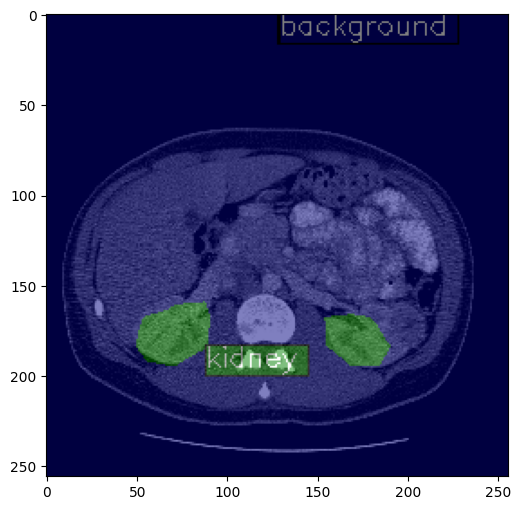

In [20]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = 'work_dirs/Seg_Swin_v2/batch16lr0.01epoch200/iter_22100.pth'
model = init_model(cfg, checkpoint_path,'cuda:0')

img = mmcv.imread('/home/modan9012/mmsegmentation/datasets/images/086_040.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [9]:
import shutil

# 압축할 폴더 경로
directory = '/home/modan9012/mmsegmentation/'

# 압축 파일의 경로 및 이름 (확장자 제외)
output_filename = '/home/modan9012/mmsegmentation'

# 폴더를 ZIP 파일로 압축
shutil.make_archive(output_filename, 'zip', directory)

print(f'{output_filename}.zip 파일이 생성되었습니다.')

/home/modan9012/Seg-Swin_v2/.zip 파일이 생성되었습니다.
